In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import glob
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../../sample_scripts/')
# from sample_scripts.sample_utils.inference_utils import to_tensor
# from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("../../config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [2]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_cond_model.in_image = cfg.img_cond_model.in_image + ['faceseg_bg_noface&nohair'] + ['faceseg_eyes']
cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
img_ext = '.jpg'
cfg.dataset.training_data = 'ffhq_256_with_anno'
cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)
print(dataset.__len__())

[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead', 'faceseg_bg_noface&nohair', 'faceseg_eyes']
DPM Image condition :  [None]
10000


creating the FLAME Decoder
['/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256//valid/67887.jpg'] ['67887.jpg']
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
1 1
[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0


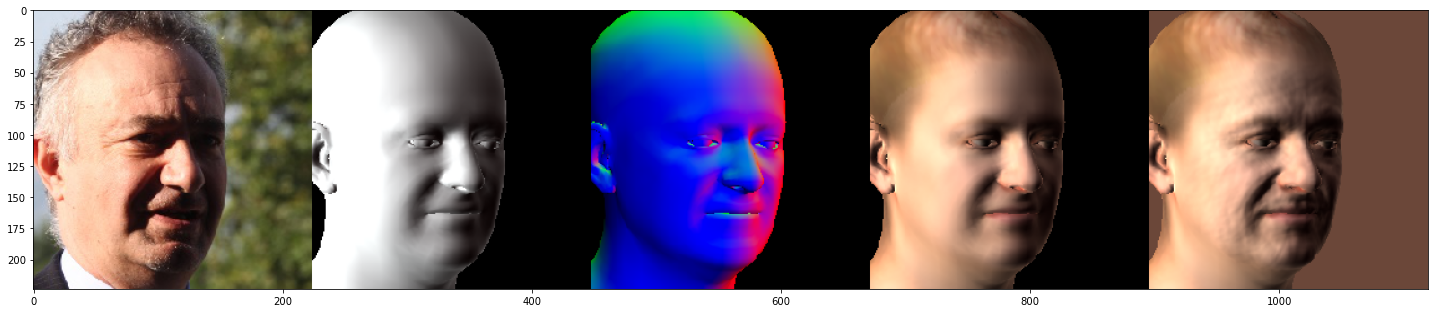

creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
1 1
[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0


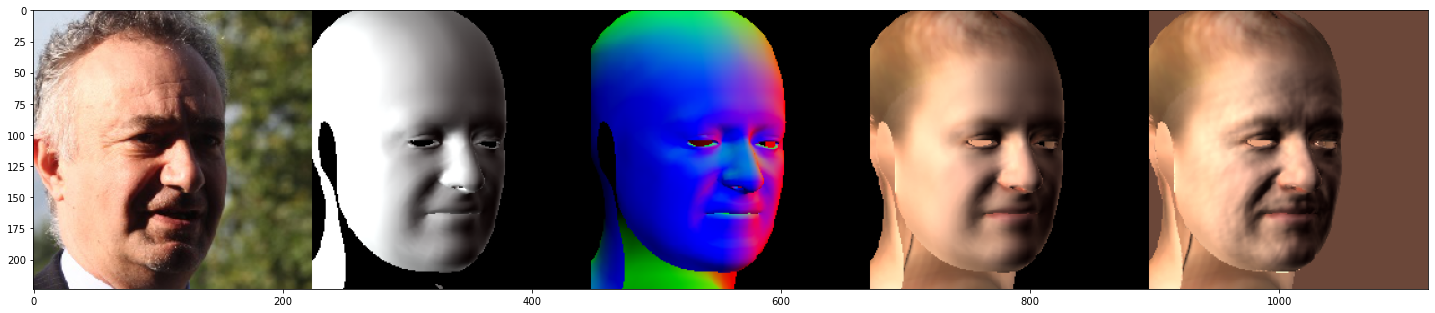

creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
1 1
[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0


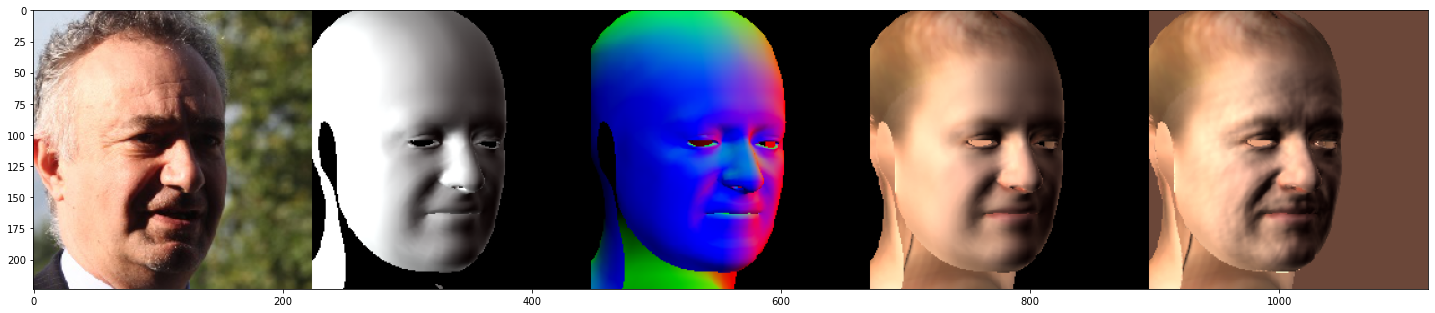

In [7]:
from importlib import reload
sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
# sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = False

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() 
}        
deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=None)
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

mask_head = {
    'v_mask':v_mask['face'].tolist() + v_mask['scalp'].tolist(),
    'f_mask':f_mask['face'].tolist() + f_mask['scalp'].tolist()
}


img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['67887.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1000,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
print(model_kwargs['raw_image_path'], model_kwargs['image_name'])
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=1, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=None, repeat=False)
orig_visdict = dict((k, orig_visdict[k]) for k in ['inputs', 'shape_images', 'normal_images', 'rendered_images', 'rendered_images_pred_detail'])
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=1, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=mask_head, repeat=False)
orig_visdict = dict((k, orig_visdict[k]) for k in ['inputs', 'shape_images', 'normal_images', 'rendered_images', 'rendered_images_pred_detail'])
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=1, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=mask_head, repeat=False)
orig_visdict = dict((k, orig_visdict[k]) for k in ['inputs', 'shape_images', 'normal_images', 'rendered_images', 'rendered_images_pred_detail'])
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()